In [1]:
!git clone https://github.com/pytorch-labs/float8_experimental.git

Cloning into 'float8_experimental'...


In [3]:
!pip install -e float8_experimental/

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Obtaining file:///C:/Users/st7ma/FP8/float8_experimental
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Checking if build backend supports build_editable: started
  Checking if build backend supports build_editable: finished with status 'done'
  Getting requirements to build editable: started
  Getting requirements to build editable: finished with status 'done'
  Preparing editable metadata (pyproject.toml): started
  Preparing editable metadata (pyproject.toml): finished with status 'done'
     -------------------------------------- 266.3/266.3 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: 

In [6]:

import torch
import torch.nn as nn
from float8_experimental.float8_dynamic_linear import Float8DynamicLinear
from float8_experimental.float8_linear import Float8Linear
from float8_experimental.float8_linear_utils import (
    get_float8_linear,
    linear_requires_sync,
    LinearType,
    swap_linear_with_float8_linear,
    sync_float8_amax_and_scale_history,
)
from float8_experimental.float8_python_api import mm_float8
from float8_experimental.float8_tensor import Float8Tensor
from float8_experimental.float8_utils import (
    amax_to_scale,
    compute_error,
    E4M3_MAX_POS,
    E5M2_MAX_POS,
    FP16_MAX_POS,
    tensor_to_scale,
)
from tqdm import tqdm
UNIQUE5=torch.empty(size=(0,),dtype=torch.float32)
UNIQUE4=torch.empty(size=(0,),dtype=torch.float32)
with torch.no_grad():
    
    b=torch.rand(3000000)*2
    UNIQUE4=b.to(torch.float8_e4m3fn).to(torch.float32).unique()

    print("done1")
        
    b=torch.rand(3000000)*2

    UNIQUE5=b.to(torch.float8_e5m2).to(torch.float32).unique()
    print("done2")

arr5=UNIQUE5.numpy()
arr4=UNIQUE4.numpy()


done1
done2


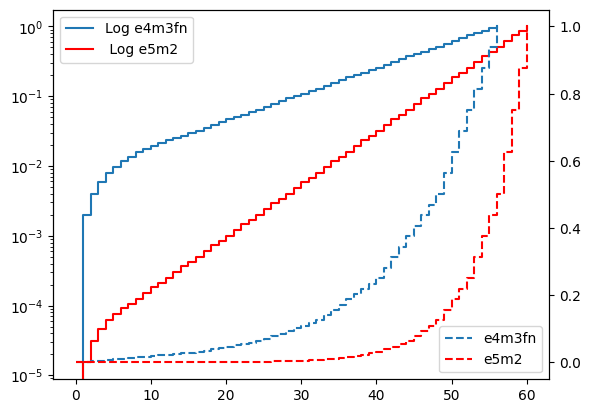

In [26]:
from matplotlib import pyplot as plt
import numpy as np
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax1.step(np.arange(len(arr4)), arr4, where='post', label='Log e4m3fn',)
#ax1.scatter(np.arange(len(arr4)), arr4,s=0.5, c='b', marker="s", label='e4m3fn')
ax1.step(np.arange(len(arr5)), arr5, where='post',c="r", label=' Log e5m2')
plt.legend(loc='upper left')
ax1.set_yscale("log")
#ax1.scatter(np.arange(len(arr5)),arr5, c='r',s=0.5, marker="o", label='e5m2')
ax2 = ax1.twinx()
ax2.step(np.arange(len(arr4)), arr4, where='post',  linestyle='--',label='e4m3fn')
#ax1.scatter(np.arange(len(arr4)), arr4,s=0.5, c='b', marker="s", label='e4m3fn')
ax2.step(np.arange(len(arr5)), arr5, where='post',c="r",  linestyle='--',label='e5m2')
ax2.set_yscale("linear")
plt.legend(loc='lower right')
plt.show()

In [4]:
import wandb
from tqdm import tqdm
from itertools import chain
wandb.login()
api = wandb.Api(timeout=45)
entity, project = "st7ma784", "8BitPrecisionTest"
runs = api.runs(entity + "/" + project)
data=[]
for run in runs:
    dic=run.history()
    array=dic['input to LSA']
    data.append(array)
    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


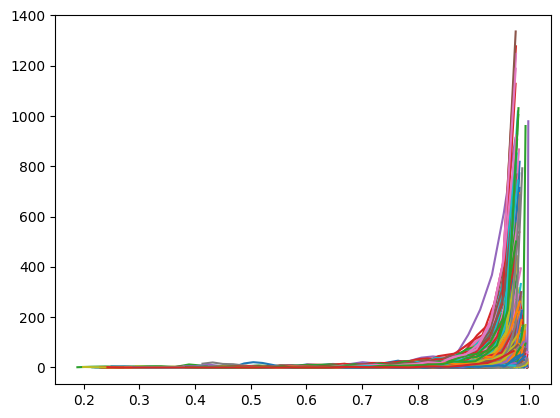

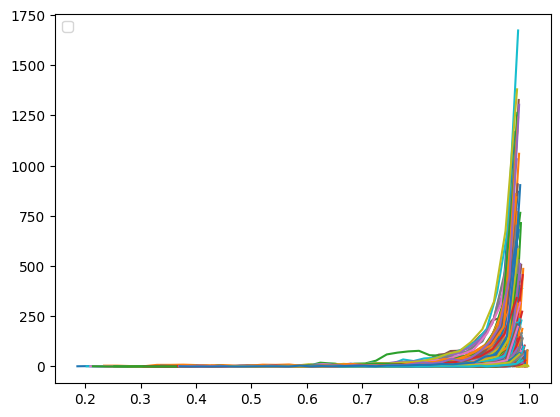

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for d in data:
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    for entry in d:
        
        if entry is not None and not isinstance(entry,list) and not isinstance(entry,float):
            y=None
            if "bins" in entry:
                x=entry["bins"]
            elif "packedBins" in entry:
                deets=entry["packedBins"]
                dist=deets['size']*deets["count"]
                x=np.linspace(start=deets["min"],
                              stop=deets["min"]+dist,
                              num=deets["count"],
                              endpoint=False)
            y=entry["values"]

            ax1.plot(x[:len(y)],y)
#ax1.scatter(np.arange(len(arr4)), arr4,s=0.5, c='b', marker="s", label='e4m3fn')
plt.legend(loc='upper left')
    # figure=plt.figure(0)
    # table = wandb.Table(data=d, columns=["scores"])
    # wandb.log({'my_histogram': wandb.plot.histogram(table, "scores",
 	#   title="Prediction Score Distribution")})


Indexes with 8-bit precision: 
77.39160919189453
Indexes with 8-bit precision: 
69.29377746582031
Indexes with 16-bit precision: 
81.27843475341797
Indexes with 32-bit precision: 
81.16217041015625


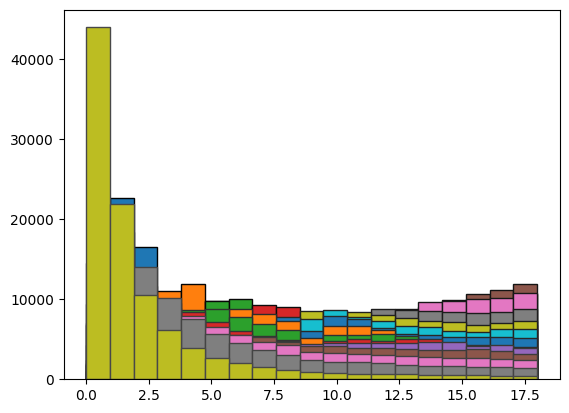

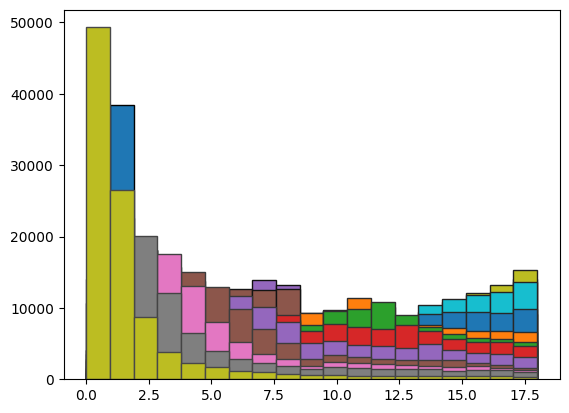

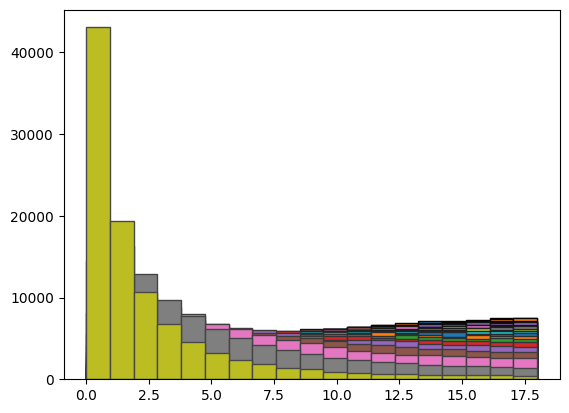

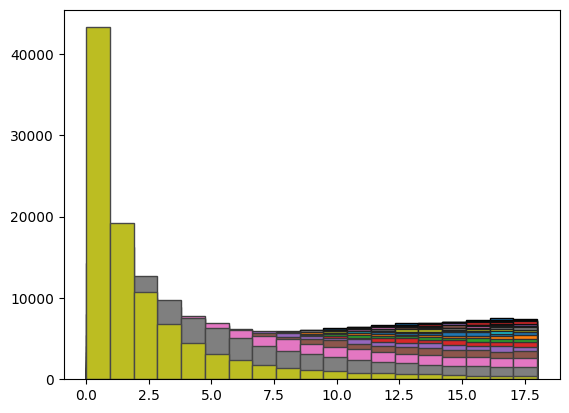

In [38]:
import torch
import matplotlib.pyplot as plt
import torch

# Test the function with a 2D tensor

def calculate_probability(width, height, precision_bits,dist="random"):
    # Generate a random float tensor with the specified precision

    tensor=torch.rand((width, height))
    m=torch.distributions.normal.Normal(torch.tensor(0.0),torch.tensor(1.0))
    tgt=torch.distributions.half_normal.HalfNormal(0.3)
    if dist=="normal":
        tensor=torch.normal(mean=0,std=0.2,size=(width, height))
    if dist=="best":
        tensor=torch.abs(torch.normal(mean=0,std=0.3,size=(width, height)))
        tensor=torch.abs(m.sample(torch.Size((width, height))))

    if dist=="best2":
        tensor=m.sample(torch.Size((width, height)))
        m=torch.distributions.normal.Normal(torch.tensor(0.0),torch.tensor(1.0))
        tgt=torch.distributions.half_normal.HalfNormal(0.3)
        prob=m.cdf(tensor)
        #print(torch.exp(prob))
        tensor=tgt.icdf(prob)



    if dist=="DETR":
        tensor=1-torch.abs(torch.normal(mean=0,std=0.2,size=(width, height)))
    if precision_bits == 8:
        tensor = tensor.to(torch.float8_e4m3fn).to(torch.float32)  # 16-bit half precision, closest to 8-bit
    elif precision_bits == 9:
        tensor = tensor.to(torch.float8_e5m2).to(torch.float32)  # 16-bit half precision, closest to 8-bit
    elif precision_bits == 16:
        tensor = tensor.half()  # 16-bit half precision
    # 32-bit single precision

    # Sort the tensor along each row
    sorted_tensor = tensor.sort(dim=1,descending=True).values

    # Calculate the deltas between adjacent values in each row
    deltas = torch.diff(sorted_tensor, dim=1)

    # Get the indexes that would sort the deltas
    sorted_indexes = deltas.argsort(descending=True,dim=1)

    return sorted_indexes

def plot_distributions(tensor):
    # Convert the tensor to numpy for easier processing
    stack = tensor.numpy()

    # Determine the length of the arrays (number of columns)
    length = stack.shape[1]

    # Create a figure and a set of subplots
    fig = plt.plot(figsize=(10, length*5))
    

    # For each position in the arrays
    for i in range(length):
        # Extract the values at this position from each array in the stack
        values = stack[:, i]
        # Plot a histogram of these values on the corresponding subplot
        plt.hist(values, bins=length, edgecolor=(i/64,i/64,i/64),label=f'Distribution of values at position {i}')
        # plt.set_title(f'Distribution of values at position {i}')

    # Display the plot
    # plt.tight_layout()
    #plt.legend()
    plt.show()
def calc_positional_loss(arr):
    B,d=arr.shape
    ideal_pos=torch.arange(0,d).unsqueeze(0)
    arr=torch.sub(arr,ideal_pos)
    arr=torch.pow(arr,2)
    return torch.sum(arr).div(B*d)
# Test the function with different precisions
B=1000

H=20
DIST="best2"

indexes_8bit = torch.cat([calculate_probability(B,H, 8,DIST) for _ in range(100)],dim=0)
indexes_9bit = torch.cat([calculate_probability(B,H, 9,DIST) for _ in range(100)],dim=0)

indexes_16bit = torch.cat([calculate_probability(B,H, 16,DIST) for _ in range(100)],dim=0)

indexes_32bit = torch.cat([calculate_probability(B,H, 32,DIST) for _ in range(100)],dim=0)
print(f"Indexes with 8-bit precision: \n{calc_positional_loss(indexes_8bit)}")
print(f"Indexes with 8-bit precision: \n{calc_positional_loss(indexes_9bit)}")

print(f"Indexes with 16-bit precision: \n{calc_positional_loss(indexes_16bit)}")

print(f"Indexes with 32-bit precision: \n{calc_positional_loss(indexes_32bit)}")

plot_distributions(indexes_8bit)

plot_distributions(indexes_9bit)

plot_distributions(indexes_16bit)
plot_distributions(indexes_32bit)




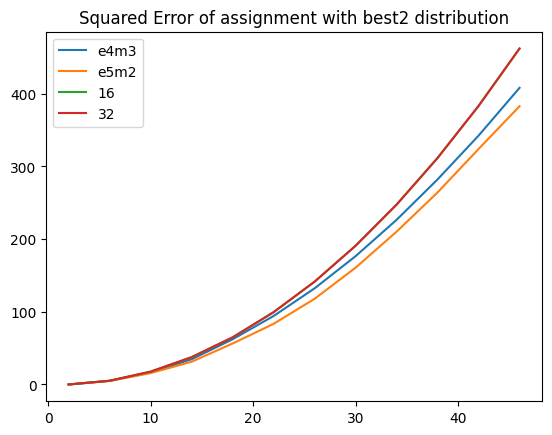

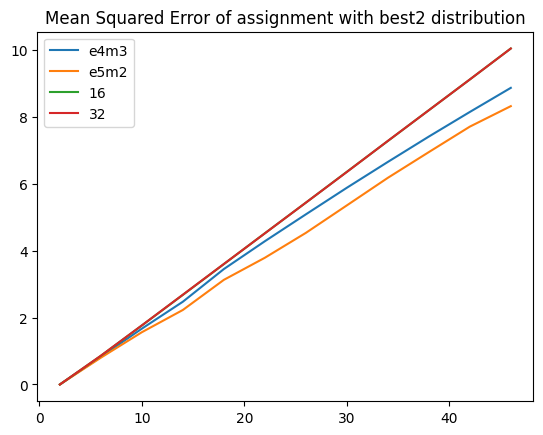

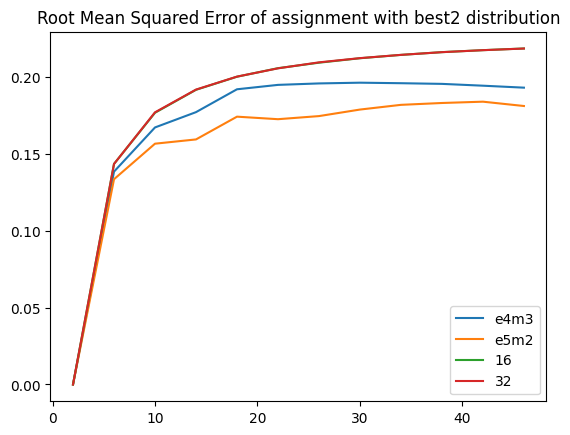

In [39]:
B=1000
DISTs=["best2"]#"random","normal","DETR","best",

x=range(2,50,4)

for DIST in DISTs:
        
    indexes_8bit = [calc_positional_loss(torch.cat([calculate_probability(B,H, 8,DIST) for _ in range(100)],dim=0)) for H in range(2,50,4)]
    indexes_9bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 9,DIST) for _ in range(100)],dim=0))  for H in range(2,50,4)]

    indexes_16bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 16,DIST) for _ in range(100)],dim=0))  for H in range(2,50,4)]

    indexes_32bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 32,DIST) for _ in range(100)],dim=0))  for H in range(2,50,4)]

    plt.plot(x,indexes_8bit,label="e4m3")
    plt.plot(x,indexes_9bit,label="e5m2")
    plt.plot(x,indexes_16bit,label="16")
    plt.plot(x,indexes_32bit,label="32")
    plt.legend()
    plt.title("Squared Error of assignment with {} distribution".format(DIST))
    plt.show()

    indexes_8bit = [calc_positional_loss(torch.cat([calculate_probability(B,H, 8,DIST) for _ in range(100)],dim=0))/(H) for H in range(2,50,4)]
    indexes_9bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 9,DIST) for _ in range(100)],dim=0))/(H)  for H in range(2,50,4)]

    indexes_16bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 16,DIST) for _ in range(100)],dim=0))/(H)  for H in range(2,50,4)]

    indexes_32bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 32,DIST) for _ in range(100)],dim=0))/(H)  for H in range(2,50,4)]

    plt.plot(x,indexes_8bit,label="e4m3")
    plt.plot(x,indexes_9bit,label="e5m2")
    plt.plot(x,indexes_16bit,label="16")
    plt.plot(x,indexes_32bit,label="32")
    plt.legend()
    plt.title("Mean Squared Error of assignment with {} distribution".format(DIST))

    plt.show()



    indexes_8bit = [calc_positional_loss(torch.cat([calculate_probability(B,H, 8,DIST) for _ in range(100)],dim=0))/(H*H) for H in range(2,50,4)]
    indexes_9bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 9,DIST) for _ in range(100)],dim=0))/(H*H)  for H in range(2,50,4)]

    indexes_16bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 16,DIST) for _ in range(100)],dim=0))/(H*H)  for H in range(2,50,4)]

    indexes_32bit =  [calc_positional_loss(torch.cat([calculate_probability(B,H, 32,DIST) for _ in range(100)],dim=0))/(H*H)  for H in range(2,50,4)]

    plt.plot(x,indexes_8bit,label="e4m3")
    plt.plot(x,indexes_9bit,label="e5m2")
    plt.plot(x,indexes_16bit,label="16")
    plt.plot(x,indexes_32bit,label="32")
    plt.legend()
    plt.title("Root Mean Squared Error of assignment with {} distribution".format(DIST))

    plt.show()

